In [1]:
# random forest classifier
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt


# f1, precision, recall, weighted accuracy
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    make_scorer,
    balanced_accuracy_score,
)

# xgboost classifier

from xgboost import XGBClassifier

# lightgbm classifier

from lightgbm import LGBMClassifier

# catboost classifier

from catboost import CatBoostClassifier

import pandas as pd

# Adaboot classifier
from sklearn.ensemble import AdaBoostClassifier

In [2]:
RAW_DIR = "data/raw"
PROCESSED_DIR = "data/processed"

In [3]:
dataset = pd.read_csv(f"{RAW_DIR}/fetal_health.csv")

## Removing histogram features 
'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency',

In [7]:
# Remove columns that have histogram data

dataset_without_hist = dataset.drop(columns=['histogram_width',
                                    'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
                                             'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
                                             'histogram_median', 'histogram_variance', 'histogram_tendency'])

In [8]:
dataset_without_hist.columns

Index(['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'fetal_health'],
      dtype='object')

In [55]:
label2class = {
    1: "Normal",
    2: "Suspect",
    3: "Pathology"
}

labeel2class_encoded = {
    0: "Normal",
    1: "Suspect",
    2: "Pathology"
}

In [4]:
# split (train, test) stratified and save into processed directory

train, test = train_test_split(
    dataset, test_size=0.1, stratify=dataset["fetal_health"], random_state=42
)

train.to_csv(f"{PROCESSED_DIR}/train.csv", index=False)

test.to_csv(f"{PROCESSED_DIR}/test.csv", index=False)

In [9]:
train_without_hist, test_without_hist = train_test_split(
    dataset_without_hist, test_size=0.1, stratify=dataset_without_hist["fetal_health"], random_state=42
)

train_without_hist.to_csv(
    f"{PROCESSED_DIR}/train_without_hist.csv", index=False)

test_without_hist.to_csv(f"{PROCESSED_DIR}/test_without_hist.csv", index=False)

In [5]:
x_train = train.drop("fetal_health", axis=1)
y_train = train["fetal_health"]

y_train = LabelEncoder().fit_transform(y_train)

In [10]:
x_train_without_hist = train_without_hist.drop("fetal_health", axis=1)
y_train_without_hist = train_without_hist["fetal_health"]

y_train_without_hist = LabelEncoder().fit_transform(y_train_without_hist)

In [7]:
x_train.shape, y_train.shape

((1913, 21), (1913,))

In [11]:
x_train_without_hist.shape, y_train_without_hist.shape

((1913, 11), (1913,))

In [25]:
models = [
    ("Random Forest", RandomForestClassifier()),
    ("XGBoost", XGBClassifier()),
    ("LightGBM", LGBMClassifier(verbosity=-1)),
    ("CatBoost", CatBoostClassifier(logging_level="Silent")),
    ("AdaBoost", AdaBoostClassifier(n_estimators=1000)),
]

In [26]:
scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
    "precision": make_scorer(precision_score, average="weighted"),
    "recall": make_scorer(recall_score, average="weighted"),
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
}

In [27]:
FOLDS = 10

In [38]:
def get_scores(scores):
    AVG_F1 = np.mean(scores["test_f1"])
    AVG_PRECISION = np.mean(scores["test_precision"])
    AVG_RECALL = np.mean(scores["test_recall"])
    AVG_BALANCED_ACCURACY = np.mean(scores["test_balanced_accuracy"])

    print(f"Average F1: {AVG_F1}")
    print(f"Average Precision: {AVG_PRECISION}")
    print(f"Average Recall: {AVG_RECALL}")
    print(f"Average Balanced Accuracy: {AVG_BALANCED_ACCURACY}")

    return {
        "avg_f1": AVG_F1,
        "avg_precision": AVG_PRECISION,
        "avg_recall": AVG_RECALL,
        "avg_balanced_accuracy": AVG_BALANCED_ACCURACY,
    }

In [39]:
dict_of_results = {model: {} for model, _ in models}


# test every model and every metric
for model_name, model in models:
    scores = cross_validate(
        model,
        x_train,
        y_train,
        scoring=scoring,
        cv=FOLDS,
        return_train_score=True,
    )

    print(f"Model: {model_name}")

    dict_of_results[model_name] = get_scores(scores)

Model: Random Forest
Average F1: 0.9444945860030355
Average Precision: 0.9457332570139009
Average Recall: 0.9461714659685864
Average Balanced Accuracy: 0.8822548637090024
Model: XGBoost
Average F1: 0.9517256752191742
Average Precision: 0.9529604096258378
Average Recall: 0.9529586605584642
Average Balanced Accuracy: 0.897111664667593
Model: LightGBM
Average F1: 0.9560975809807569
Average Precision: 0.9573152149472535
Average Recall: 0.9571444153577662
Average Balanced Accuracy: 0.9030659807113945
Model: CatBoost
Average F1: 0.9529734702556732
Average Precision: 0.9541442828308326
Average Recall: 0.9540030541012217
Average Balanced Accuracy: 0.897886830859426


/home/gobots/.local/share/virtualenvs/MC906-ztYv0O8D/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/gobots/.local/share/virtualenvs/MC906-ztYv0O8D/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/gobots/.local/share/virtualenvs/MC906-ztYv0O8D/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/gobots/.local/share/virtualenvs/MC906-ztYv0O8D/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The

Model: AdaBoost
Average F1: 0.8597237269999807
Average Precision: 0.8651116630713119
Average Recall: 0.8588350785340314
Average Balanced Accuracy: 0.7566041144396849


In [40]:
dict_of_results_without_histogram = {model: {} for model, _ in models}


# test every model and every metric
for model_name, model in models:
    scores = cross_validate(
        model,
        x_train_without_hist,
        y_train_without_hist,
        scoring=scoring,
        cv=FOLDS,
        return_train_score=True,
    )

    print(f"Model: {model_name}")

    dict_of_results_without_histogram[model_name] = get_scores(scores)

Model: Random Forest
Average F1: 0.9406011371122334
Average Precision: 0.9418730551342431
Average Recall: 0.9425010907504362
Average Balanced Accuracy: 0.8761106178024523
Model: XGBoost
Average F1: 0.9411223079880833
Average Precision: 0.9420874660549489
Average Recall: 0.9425038176265271
Average Balanced Accuracy: 0.8812123724567795
Model: LightGBM
Average F1: 0.9347609817754325
Average Precision: 0.9362383886154968
Average Recall: 0.9362347294938917
Average Balanced Accuracy: 0.8653958654489975
Model: CatBoost
Average F1: 0.9452107879564897
Average Precision: 0.9465780607616188
Average Recall: 0.946689572425829
Average Balanced Accuracy: 0.8834470210616743


/home/gobots/.local/share/virtualenvs/MC906-ztYv0O8D/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/gobots/.local/share/virtualenvs/MC906-ztYv0O8D/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/gobots/.local/share/virtualenvs/MC906-ztYv0O8D/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/gobots/.local/share/virtualenvs/MC906-ztYv0O8D/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The

Model: AdaBoost
Average F1: 0.8591635484719159
Average Precision: 0.8642826210803447
Average Recall: 0.859396815008726
Average Balanced Accuracy: 0.7539479720212381


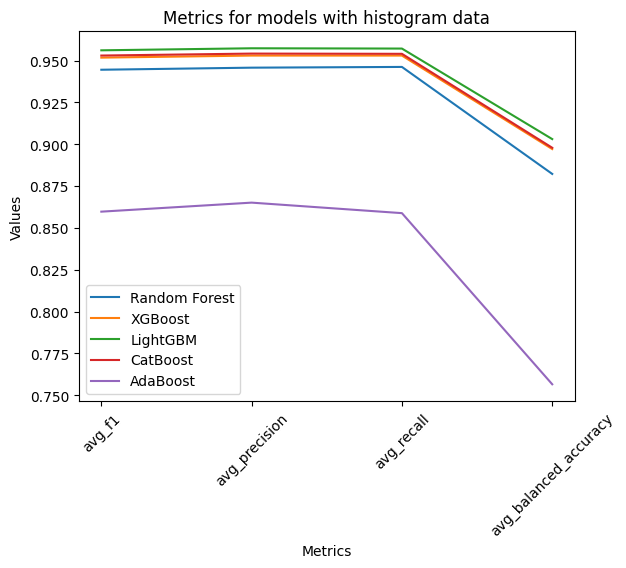

In [41]:
# plot all the results in the same plot

fig, ax = plt.subplots()

for model_name, model in models:
    ax.plot(
        list(dict_of_results[model_name].keys()),
        list(dict_of_results[model_name].values()),
        label=f"{model_name}",
    )

ax.legend()
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Metrics for models with histogram data")
# roate x labels
plt.xticks(rotation=45)

plt.show()

In [37]:
# plot all results in a graph for each metric
def plot_results(results, metric):
    plt.figure(figsize=(10, 5))
    # line plot
    plt.plot(
        list(results.keys()),
        [results[model][metric] for model in results.keys()],
        marker="o",
    )

    plt.title(f"{metric} for each model")
    plt.xlabel("Model")
    plt.ylabel(metric)

    plt.xticks(rotation=45)

    plt.show()

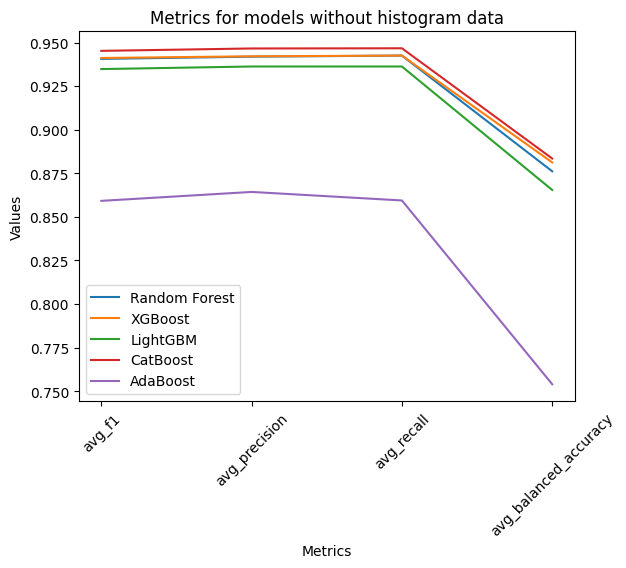

In [42]:
# plot all results in a graph for each metric
# plot all the results in the same plot

fig, ax = plt.subplots()

for model_name, model in models:
    ax.plot(
        list(dict_of_results_without_histogram[model_name].keys()),
        list(dict_of_results_without_histogram[model_name].values()),
        label=f"{model_name}",
    )

ax.legend()
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Metrics for models without histogram data")
# roate x labels
plt.xticks(rotation=45)

plt.show()

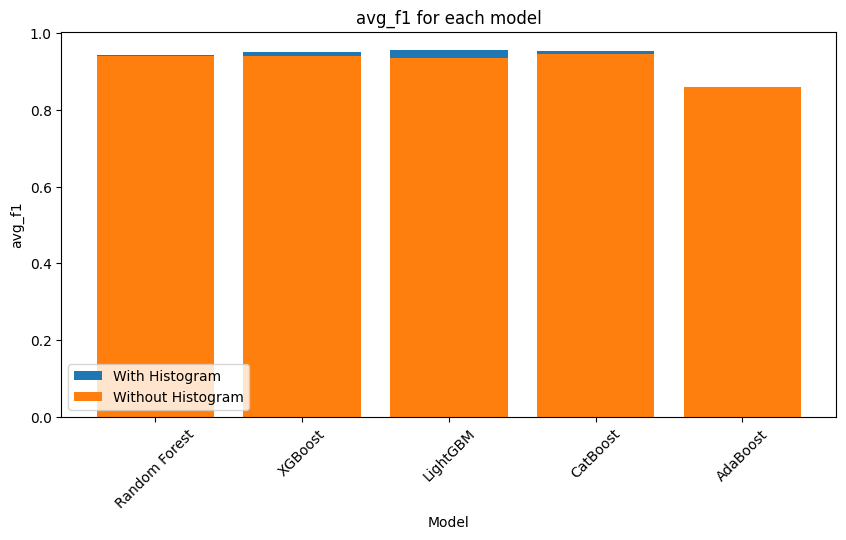

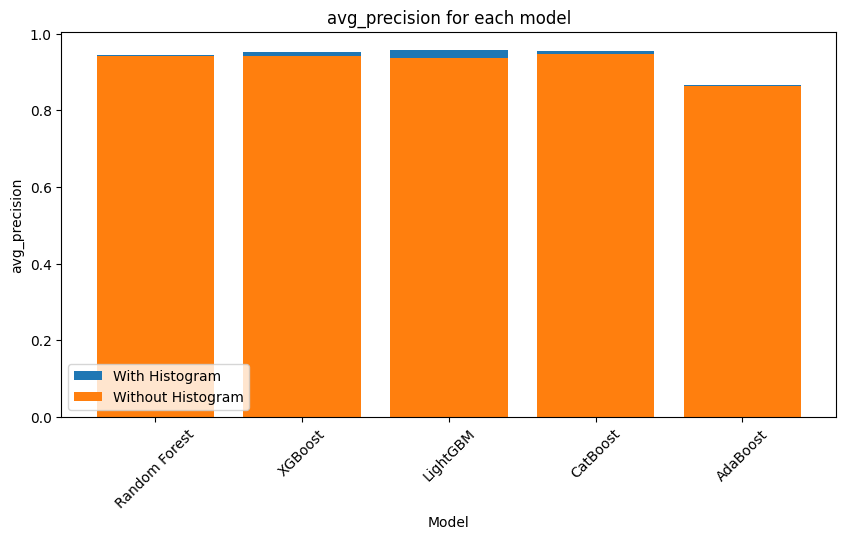

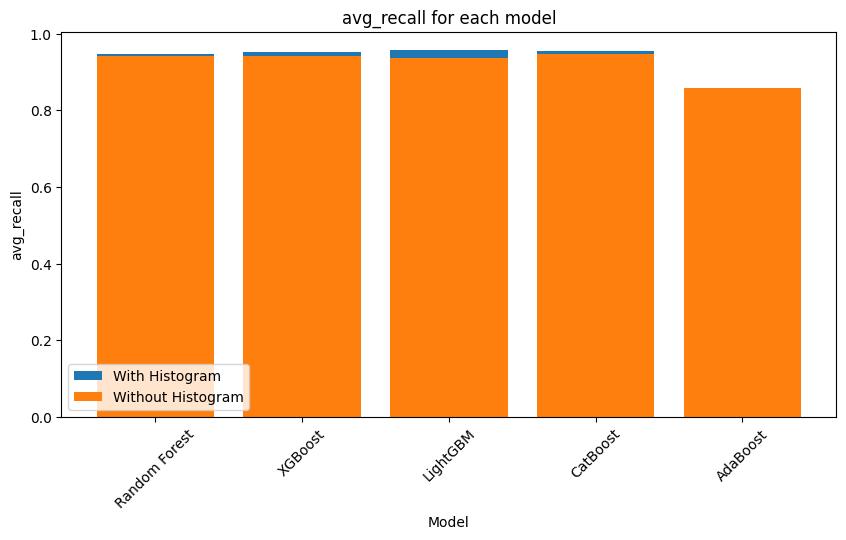

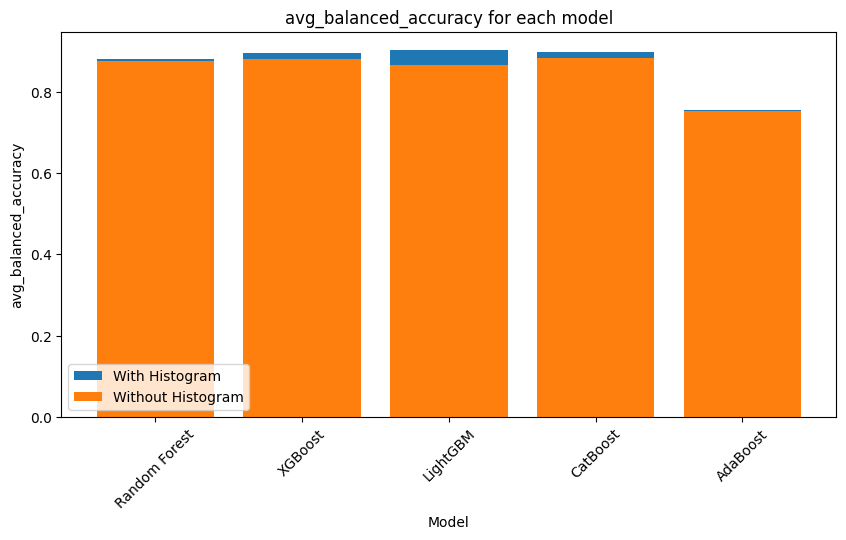

In [59]:
# compare results with and without histogram

for metric in ["avg_f1", "avg_precision", "avg_recall", "avg_balanced_accuracy"]:
    plt.figure(figsize=(10, 5))
    # line plot
    plt.bar(
        list(dict_of_results.keys()),
        [dict_of_results[model][metric] for model in dict_of_results.keys()],
        label="With Histogram",
    )

    plt.bar(
        list(dict_of_results_without_histogram.keys()),
        [dict_of_results_without_histogram[model][metric]
            for model in dict_of_results_without_histogram.keys()],
        label="Without Histogram",
    )

    plt.title(f"{metric} for each model")
    plt.xlabel("Model")
    plt.ylabel(metric)
    plt.legend()
    plt.xticks(rotation=45)

    plt.legend(loc="lower left")
    plt.show()

In [ ]:
# test the model with the test set
test_results = {model: {} for model, _ in models}


def test_model(model, x_test, y_test):
    y_test = LabelEncoder().fit_transform(y_test)

    y_pred = model.predict(x_test)

    f1 = f1_score(y_test, y_pred, average="weighted")
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

    print(f"F1: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Balanced Accuracy: {balanced_accuracy}")

    return {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "balanced_accuracy": balanced_accuracy,
    }


x_test = test.drop("fetal_health", axis=1)

y_test = test["fetal_health"]


# test with the test set with all models


for model_name, model in models:
    model.fit(x_train, y_train)
    print(f"Model: {model_name}")
    test_results[model_name] = test_model(model, x_test, y_test)

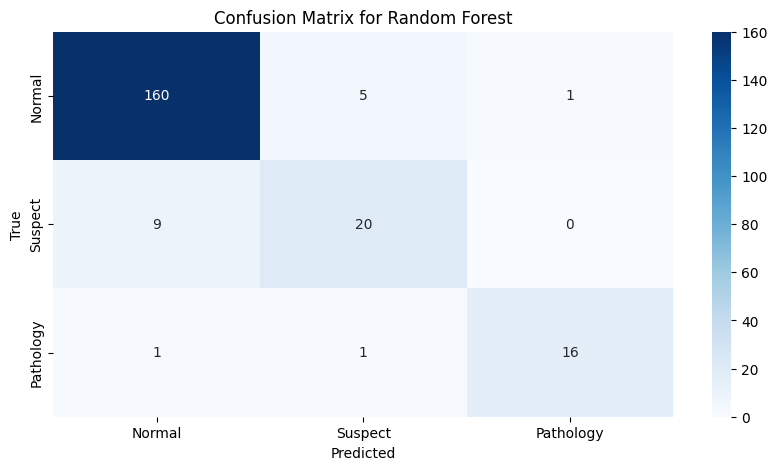

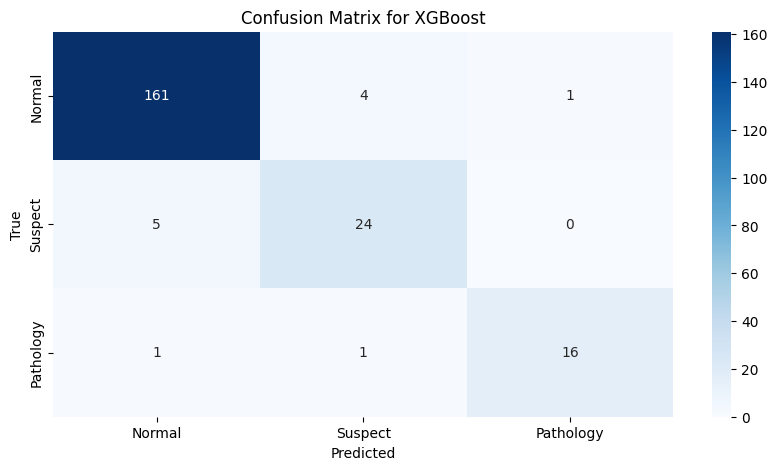

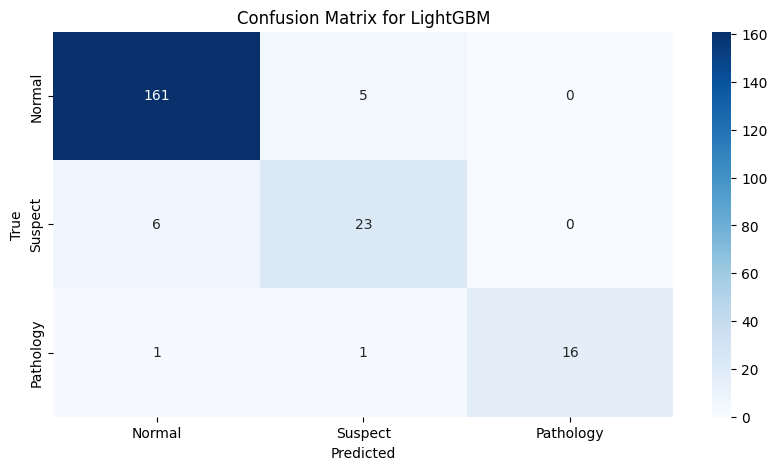

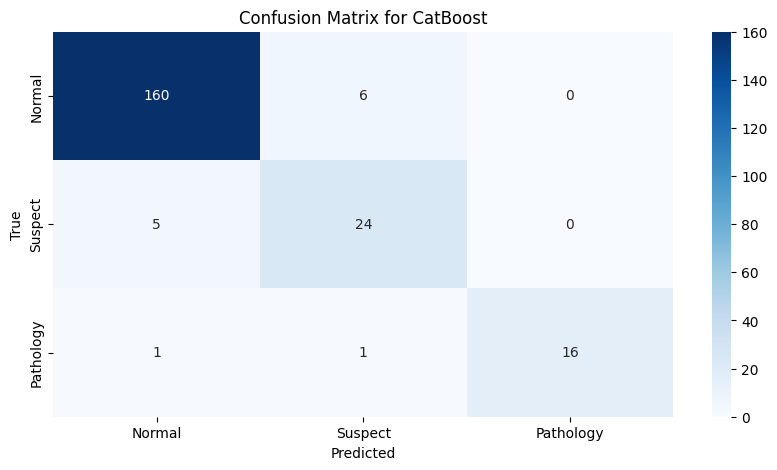

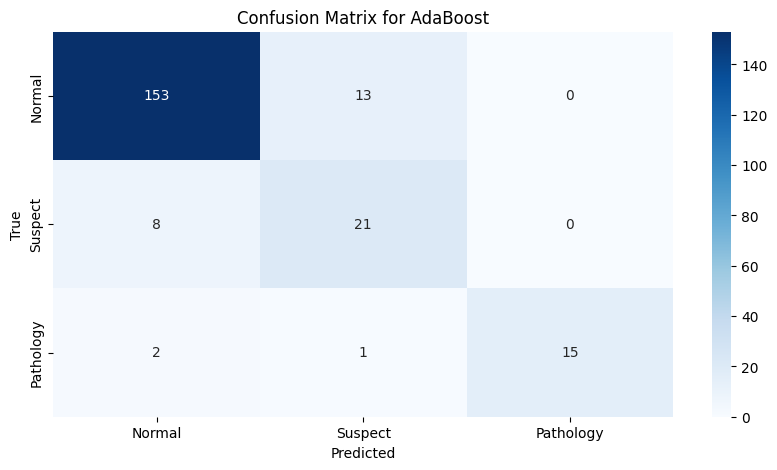

In [60]:
# matrix confusion
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_test = LabelEncoder().fit_transform(y_test)



for model_name, model in models:
    y_pred = model.predict(x_test)

    c = confusion_matrix(y_test, y_pred)

    # plot

    plt.figure(figsize=(10, 5))

    sns.heatmap(c, annot=True, fmt="d", cmap="Blues",
                xticklabels=[label2class[i] for i in range(1, 4)],
                yticklabels=[label2class[i] for i in range(1, 4)])
                

    plt.title(f"Confusion Matrix for {model_name}")

    plt.xlabel("Predicted")
    plt.ylabel("True")


plt.show()

Feature Importance for LightGBM


<Figure size 1000x500 with 0 Axes>

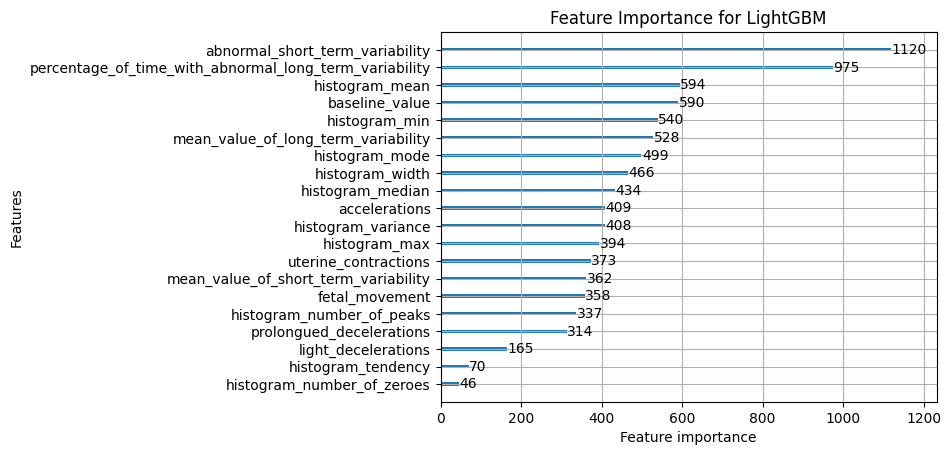

In [16]:
# plot imporante for the best model
print(f"Feature Importance for {best_model[0]}")
plt.figure(figsize=(10, 5))

if best_model[0] == "Random Forest":

    plt.barh(x_train.columns, model.feature_importances_)

    plt.title("Feature Importance for Random Forest")


elif best_model[0] == "XGBoost":

    from xgboost import plot_importance

    plot_importance(model, title="Feature Importance for XGBoost")


elif best_model[0] == "LightGBM":

    from lightgbm import plot_importance

    plot_importance(model, title="Feature Importance for LightGBM")


elif best_model[0] == "CatBoost":

    plt.figure(figsize=(10, 5))

    model.get_feature_importance(prettified=True).plot.barh(
        x="Feature Id", y="Importances"
    )

    plt.title("Feature Importance")


plt.show()